# Problem

**State space.**
The states are encoded as integers
$$\mathcal{X} = {0,1,\dots,8} $$
corresponding to the grid in row-major order (top-left corner to bottom-right corner). State $8$ is the terminal goal state and is absorbing.

**Action space.**
Actions are represented as integers

$$ \mathcal{A} = {0,1,2,3} $$

where $0 =$ Up, $1 =$ Down, $2 =$ Left, $3 =$ Right.

**Transition dynamics.**
Transitions are deterministic. For any state $x$ and action $a$, the state index is first mapped to its grid coordinates $(r,c)$, the action moves the agent one step (unless this would leave the grid), and the result is mapped back to a state index. The goal state $8$ always transitions to itself.
The transition matrix $P$ has shape $(|\mathcal{X}||\mathcal{A}|) \times |\mathcal{X}| = 36 \times 9$, where each row corresponds to a pair $(x,a)$ and contains a one-hot vector indicating the unique next state:

$$P[(x,a),x'] = 1 \quad \text{iff } x' = \text{next\_state}(x,a)$$

and $0$ otherwise.

**Reward model.**
Thus $r(x,a) = 1$ only when $x$ is the goal state, and $0$ otherwise.

**Initial state.**
The initial state is fixed as $x_0 = 0$.

In [12]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import sys
from pathlib import Path

PROJECT_ROOT = Path(os.getcwd()).resolve().parents[0]
# Add project root to the Python path
sys.path.append(str(PROJECT_ROOT))
# Define dataset path
DATASET_PATH = PROJECT_ROOT / "datasets" / "grid3_problem.csv"

from fogas import FOGASSolverVectorized, FOGASOracleSolverVectorized, FOGASHyperOptimizer, FOGASEvaluator, PolicySolver

seed = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Tabular Features

## Definition

### Description

**Feature Map**

We use a tabular one-hot feature representation over state–action pairs.
Each feature corresponds to a unique \((x,a)\) combination.

The feature map is defined as:
$$
\phi(x,a) \in \mathbb{R}^{36}
$$
with the ordering
$$
(x,a) \;\longrightarrow\; e_{\,x \cdot |\mathcal{A}| + a}
\quad |\mathcal{A}| = 4
$$

**Reward Weights**

The reward function is linear in the features:
$$
r(x,a) = \phi(x,a)^\top \omega.
$$

The weight vector $\omega \in \mathbb{R}^{36}$ is defined as:
$$
\omega_i =
\begin{cases}
1 & \text{if } i \in \{8\cdot 4,\, 8\cdot 4 + 1,\, 8\cdot 4 + 2,\, 8\cdot 4 + 3\}, \\
0 & \text{otherwise}.
\end{cases}
$$

This yields:
$$
r(x,a) =
\begin{cases}
1 & \text{if } x = 8 \;\;(\text{goal state}), \\
0 & \text{otherwise}.
\end{cases}
$$

**Transition Weights**

For each $x' \in \mathcal{X}$,
$$
\psi(x')_i =
\begin{cases}
1 & \text{if } i = 4x + a \text{ and } x' = \text{next\_state}(x,a), \\
0 & \text{otherwise}.
\end{cases}
$$

Equivalently, stacking $\psi(x')$ for all $x'$ recovers the tabular
transition matrix
$$
P \in \mathbb{R}^{36 \times 9}
$$
where each row $(x,a)$ contains a single 1 at the column corresponding
to $\text{next\_state}(x,a)$.

The terminal goal state $x = 8$ is absorbing, so for all actions $a$,
$$
\text{next\_state}(8,a) = 8
$$


## Testing

In [13]:
states = np.arange(9)
actions = np.arange(4)
N = len(states) # number of states
A = len(actions) # number of actions
gamma = 0.9

x_0 = 0 # fixed initial state

goal_grid = 8   # absorbing terminal state

def phi(x, a):
    vec = np.zeros(N * A)
    vec[x * A + a] = 1.0
    return vec

omega = np.zeros(N*A)
omega[8 * A : 8* A + 4] = 1

# Helper to convert index <-> (row, col)
def to_rc(s):  return divmod(s, 3)
def to_s(r,c): return r*3 + c

def next_state(s, a):
    if s == goal_grid:
        return goal_grid  # absorbing: if we reach that state we stay in that state

    r, c = to_rc(s)

    if a == 0:  # Up
        r = max(0, r-1)
    elif a == 1:  # Down
        r = min(2, r+1)
    elif a == 2:  # Left
        c = max(0, c-1)
    elif a == 3:  # Right
        c = min(2, c+1)

    return to_s(r, c)

def psi(xp):
    v = np.zeros(N * A)
    for x in states:
        for a in actions:
            if next_state(x, a) == xp:
                v[x * A + a] = 1.0
    return v

mdp = PolicySolver(states=states, actions=actions, phi=phi, omega=omega, gamma=gamma, x0=x_0, psi=psi)

### Oracle

In [14]:
solver = FOGASOracleSolverVectorized(
    mdp=mdp, 
    cov_matrix="identity", 
    print_params=True, 
    T=600
)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"), seed=seed)


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     1.0000
Num states N:             9
Num actions A:            4
Feature dim d:            36
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      9255128.526390366
T (iterations):                600   (overridden → 600)

FOGAS Hyperparameters
---------------------
alpha:                        0.001133
rho:                            5.820702
eta:                            0.000022
D_theta:                    18.973666
beta (ridge):             0.000046
D_pi (derived):           12.897881





=== FOGAS Hyperparameter Optimization ===
[Initial] metric = -0.1787
Order: ('eta', 'rho', 'alpha')

Optimizing eta
[After eta*] alpha=1.1330e-03, rho=5.0000e+00, eta=3.2366e-03 | metric = -0.4404

Optimizing rho
[After rho*] alpha=1.1330e-03, rho=1.0000e-02, eta=3.2366e-03 | metric = -0.4597

Optimizing alpha
[After alpha*] alpha=3.3463e-02, rho=1.0000e-02, eta=3.2366e-03 | metric = -0.6561


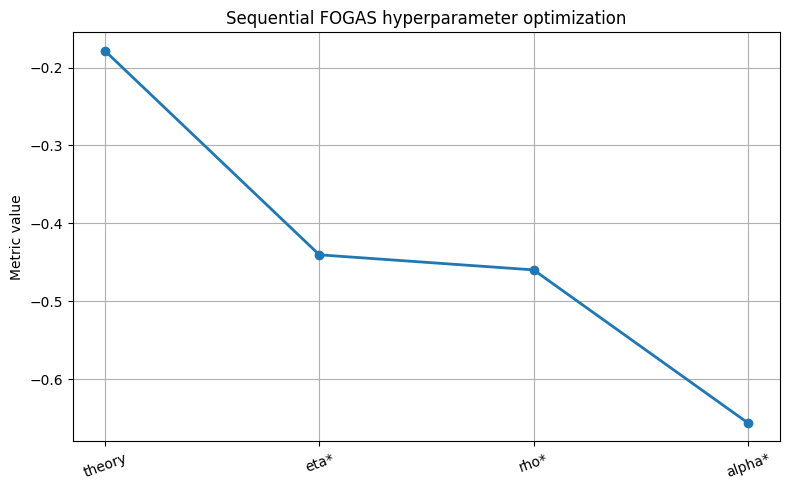

In [15]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2,
    order=("eta", "rho", "alpha")
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]

In [16]:
solver.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator.compare_value_functions()

FOGAS Oracle:   0%|          | 0/600 [00:00<?, ?it/s]

FOGAS Oracle: 100%|██████████| 600/600 [00:00<00:00, 6662.54it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  6.561000 | V^π(x) =  6.560769 | Δ = -2.314656e-04
State 1: V*(x) =  7.290000 | V^π(x) =  7.289977 | Δ = -2.288717e-05
State 2: V*(x) =  8.100000 | V^π(x) =  8.099993 | Δ = -6.509360e-06
State 3: V*(x) =  7.290000 | V^π(x) =  7.289977 | Δ = -2.288717e-05
State 4: V*(x) =  8.100000 | V^π(x) =  8.100000 | Δ = -2.365701e-07
State 5: V*(x) =  9.000000 | V^π(x) =  9.000000 | Δ = -2.624208e-07
State 6: V*(x) =  8.100000 | V^π(x) =  8.099993 | Δ = -6.509360e-06
State 7: V*(x) =  9.000000 | V^π(x) =  9.000000 | Δ = -2.624208e-07
State 8: V*(x) =  10.000000 | V^π(x) =  10.000000 | Δ = -1.243450e-14

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  5.904900 | Q^π(x,a) =  5.904692 | Δ = -2.083190e-04
(x=0, a=1): Q*(x,a) =  6.561000 | Q^π(x,a) =  6.560979 | Δ = -2.059846e-05
(x=0, a=2): Q*(x,a) =  5.904900 | Q^π(x,a) =  5.904692 | Δ = -2.083190e-04
(x=0, a=3): Q*(x,a) =  6.561000 | Q^π(x,a) =  6.560979 | Δ

### Empirical

In [17]:
solver_e = FOGASSolverVectorized(
    mdp=mdp, 
    print_params=True, 
    csv_path=str(DATASET_PATH)
)
evaluator_e = FOGASEvaluator(solver_e)
optimizer_e = FOGASHyperOptimizer(solver=solver_e,metric_callable=evaluator_e.get_metric("reward"), seed=seed)


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           150
Feature norm bound R:     1.0000
Num states N:             9
Num actions A:            4
Feature dim d:            36
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      138.8269278958555
T (iterations):                139

FOGAS Hyperparameters
---------------------
alpha:                        0.002354
rho:                            1389.672495
eta:                            0.000045
D_theta:                    18.973666
beta (ridge):             0.000200
D_pi (derived):           6.207977




Trying same optimal hyperparameters found for the oracle.

In [18]:
solver_e.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/139 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 139/139 [00:00<00:00, 6206.31it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  6.561000 | V^π(x) =  4.987770 | Δ = -1.573230e+00
State 1: V*(x) =  7.290000 | V^π(x) =  5.743745 | Δ = -1.546255e+00
State 2: V*(x) =  8.100000 | V^π(x) =  6.299668 | Δ = -1.800332e+00
State 3: V*(x) =  7.290000 | V^π(x) =  5.545153 | Δ = -1.744847e+00
State 4: V*(x) =  8.100000 | V^π(x) =  6.771493 | Δ = -1.328507e+00
State 5: V*(x) =  9.000000 | V^π(x) =  8.030924 | Δ = -9.690755e-01
State 6: V*(x) =  8.100000 | V^π(x) =  5.981482 | Δ = -2.118518e+00
State 7: V*(x) =  9.000000 | V^π(x) =  7.417846 | Δ = -1.582154e+00
State 8: V*(x) =  10.000000 | V^π(x) =  10.000000 | Δ = -1.243450e-14

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  5.904900 | Q^π(x,a) =  4.488993 | Δ = -1.415907e+00
(x=0, a=1): Q*(x,a) =  6.561000 | Q^π(x,a) =  4.990638 | Δ = -1.570362e+00
(x=0, a=2): Q*(x,a) =  5.904900 | Q^π(x,a) =  4.488993 | Δ = -1.415907e+00
(x=0, a=3): Q*(x,a) =  6.561000 | Q^π(x,a) =  5.169370 | Δ

Try first eta, end alpha


=== FOGAS Hyperparameter Optimization ===
[Initial] metric = -0.1879
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=5.0000e+00, rho=5.0000e+00, eta=4.5343e-05 | metric = -0.2729

Optimizing rho
[After rho*] alpha=5.0000e+00, rho=1.8449e-01, eta=4.5343e-05 | metric = -0.2730

Optimizing eta
[After eta*] alpha=5.0000e+00, rho=1.8449e-01, eta=5.1089e-02 | metric = -0.6561


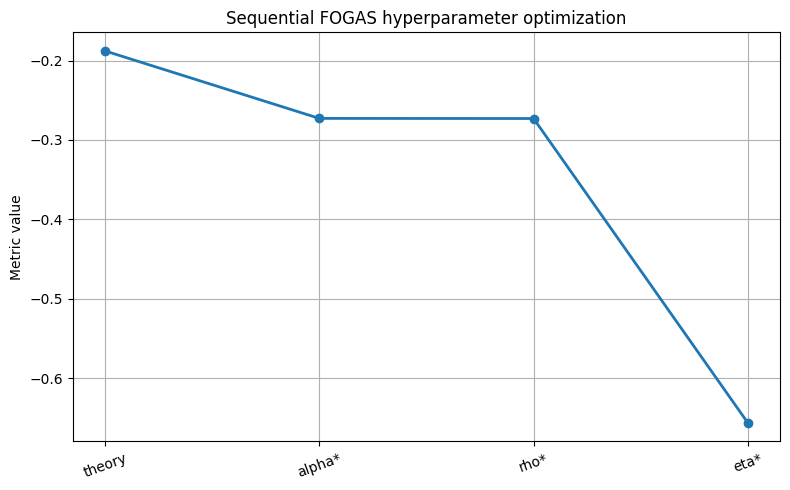

In [19]:
summary_e = optimizer_e.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2,
    order=("alpha", "rho", "eta")
)

alpha_star_e = summary_e["alpha"]
rho_star_e = summary_e["rho"]
eta_star_e = summary_e["eta"]

In [21]:
solver_e.run(alpha=alpha_star_e, eta=eta_star_e, rho=rho_star_e, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/139 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 139/139 [00:00<00:00, 6746.45it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  6.561000 | V^π(x) =  6.561000 | Δ = -4.109360e-08
State 1: V*(x) =  7.290000 | V^π(x) =  7.290000 | Δ = -4.565955e-08
State 2: V*(x) =  8.100000 | V^π(x) =  8.099851 | Δ = -1.487526e-04
State 3: V*(x) =  7.290000 | V^π(x) =  7.289986 | Δ = -1.432710e-05
State 4: V*(x) =  8.100000 | V^π(x) =  8.100000 | Δ = -6.453480e-09
State 5: V*(x) =  9.000000 | V^π(x) =  9.000000 | Δ = -7.167040e-09
State 6: V*(x) =  8.100000 | V^π(x) =  8.099375 | Δ = -6.253045e-04
State 7: V*(x) =  9.000000 | V^π(x) =  8.999305 | Δ = -6.947828e-04
State 8: V*(x) =  10.000000 | V^π(x) =  10.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  5.904900 | Q^π(x,a) =  5.904900 | Δ = -3.698424e-08
(x=0, a=1): Q*(x,a) =  6.561000 | Q^π(x,a) =  6.560987 | Δ = -1.289439e-05
(x=0, a=2): Q*(x,a) =  5.904900 | Q^π(x,a) =  5.904900 | Δ = -3.698424e-08
(x=0, a=3): Q*(x,a) =  6.561000 | Q^π(x,a) =  6.561000 | Δ

Try now first alpha and finally eta.


=== FOGAS Hyperparameter Optimization ===
[Initial] metric = -0.1879
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=5.0000e+00, rho=5.0000e+00, eta=4.5343e-05 | metric = -0.2729

Optimizing rho
[After rho*] alpha=5.0000e+00, rho=1.8449e-01, eta=4.5343e-05 | metric = -0.2730

Optimizing eta
[After eta*] alpha=5.0000e+00, rho=1.8449e-01, eta=5.1089e-02 | metric = -0.6561


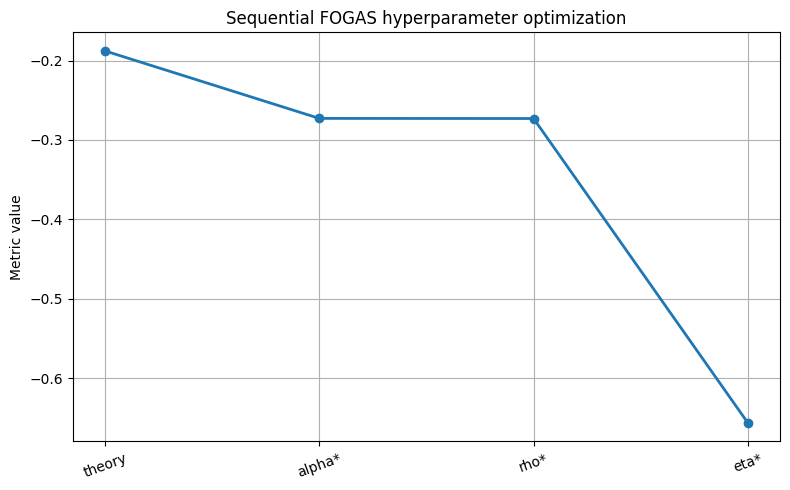

In [22]:
summary_e = optimizer_e.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2,
    order=("alpha", "rho", "eta")
)

alpha_star_e = summary_e["alpha"]
rho_star_e = summary_e["rho"]
eta_star_e = summary_e["eta"]

In [23]:
solver_e.run(alpha=alpha_star_e, eta=eta_star_e, rho=rho_star_e, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/139 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 139/139 [00:00<00:00, 4763.61it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  6.561000 | V^π(x) =  6.561000 | Δ = -4.109360e-08
State 1: V*(x) =  7.290000 | V^π(x) =  7.290000 | Δ = -4.565955e-08
State 2: V*(x) =  8.100000 | V^π(x) =  8.099851 | Δ = -1.487526e-04
State 3: V*(x) =  7.290000 | V^π(x) =  7.289986 | Δ = -1.432710e-05
State 4: V*(x) =  8.100000 | V^π(x) =  8.100000 | Δ = -6.453480e-09
State 5: V*(x) =  9.000000 | V^π(x) =  9.000000 | Δ = -7.167040e-09
State 6: V*(x) =  8.100000 | V^π(x) =  8.099375 | Δ = -6.253045e-04
State 7: V*(x) =  9.000000 | V^π(x) =  8.999305 | Δ = -6.947828e-04
State 8: V*(x) =  10.000000 | V^π(x) =  10.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  5.904900 | Q^π(x,a) =  5.904900 | Δ = -3.698424e-08
(x=0, a=1): Q*(x,a) =  6.561000 | Q^π(x,a) =  6.560987 | Δ = -1.289439e-05
(x=0, a=2): Q*(x,a) =  5.904900 | Q^π(x,a) =  5.904900 | Δ = -3.698424e-08
(x=0, a=3): Q*(x,a) =  6.561000 | Q^π(x,a) =  6.561000 | Δ

# State-aggregation Features

We did two different state-aggregation features, showing that if the feature of the action with the feature of the state are not mixed, the algorithm will not converge (the policy is completely independent of the state).

## 1 - Definition (FAILED)

**Feature Map**

We use a structured linear feature representation over state–action pairs that decomposes into row features, action features, and a terminal indicator.

The state space is a (3 \times 3) grid with
$$
\mathcal{X} = {0,\dots,8}, \quad \mathcal{A} = {0,1,2,3}.
$$

Let $ \text{row}(x) \in \{0,1,2\}$ denote the row index of state (x).
The feature map is defined as
$$
\phi(x,a) \in \mathbb{R}^{d}, \qquad d = 3 + 4 + 1 = 8.
$$

It has the following structure:
$$
\phi(x,a) =
\begin{bmatrix}
\mathbf{1}{\text{row}(x)=0} \\
\mathbf{1}{\text{row}(x)=1} \\
\mathbf{1}{\text{row}(x)=2} \\
\mathbf{1}{a=0} \\
\mathbf{1}{a=1} \\
\mathbf{1}{a=2} \\
\mathbf{1}{a=3} \\
\mathbf{1}{x = 8}
\end{bmatrix}.
$$

Thus:

* The **first 3 coordinates** encode the row of the grid.
* The **next 4 coordinates** encode the chosen action.
* The **last coordinate** is a terminal-state indicator for the goal state (x=8).

**Reward Weights**

The reward function is linear in the features:
$$
r(x,a) = \phi(x,a)^\top \omega.
$$

The weight vector $\omega \in \mathbb{R}^{8}$ is defined as
$$
\omega =
\begin{bmatrix}
0 \ 0 \ 0 \ 0 \ 0 \ 0 \ 0 \ 1
\end{bmatrix}.
$$

This yields:
$$
r(x,a) =
\begin{cases}
1 & \text{if } x = 8 \;\; (\text{goal state}), \\
0 & \text{otherwise}.
\end{cases}
$$

**Transition Model**

The transition matrix
$$
P \in \mathbb{R}^{(9\cdot 4) \times 9}
$$
is defined such that each row corresponding to $(x,a)$ contains a single 1 at column $x'$:

$$
P_{(x,a),x'} =
\begin{cases}
1 & \text{if } x' = \text{next\_state}(x,a), \\
0 & \text{otherwise}.
\end{cases}
$$


### Testing

In [14]:
states = np.arange(9)
actions = np.arange(4)
N = len(states) # number of states
A = len(actions) # number of actions
gamma = 0.9

x_0 = 0 # fixed initial state

goal = 8   # absorbing terminal state

# Helper to convert index <-> (row, col)
def to_rc(s):  return divmod(s, 3)
def to_s(r,c): return r*3 + c

d = N // 3 + A + 1
def phi(state, action):
    r, _ = to_rc(state)

    feature = np.zeros(d)
    feature[r] = 1.0
    feature[(N // 3) + action] = 1.0
    feature[d - 1] = 1.0 if state == goal else 0

    return feature

omega = np.zeros(d)
omega[d - 1] = 1.0

def next_state(s, a):
    if s == goal:
        return goal  # absorbing: if we reach that state we stay in that state

    r, c = to_rc(s)

    if a == 0:  # Up
        r = max(0, r-1)
    elif a == 1:  # Down
        r = min(2, r+1)
    elif a == 2:  # Left
        c = max(0, c-1)
    elif a == 3:  # Right
        c = min(2, c+1)

    return to_s(r, c)

P_grid = np.zeros((N * A, N))
count = 0
for x in range(N):
    for a in range(A):
        xp = next_state(x, a)     # deterministic next state
        for xp_ in range(N):
            if xp_ == xp:
                P_grid[count, xp_] = 1.0
            else:
                P_grid[count, xp_] = 0.0
        count += 1

mdp = PolicySolver(states=states, actions=actions, phi=phi, omega=omega, gamma=gamma, x0=x_0, P=P_grid)

### Oracle

In [15]:
solver = FOGASOracleSolverVectorized(
    mdp=mdp, 
    cov_matrix="identity", 
    print_params=True, 
    T=1000
)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"), seed=seed)


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     1.7321
Num states N:             9
Num actions A:            4
Feature dim d:            8
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      27765385.5791711
T (iterations):                1000   (overridden → 1000)

FOGAS Hyperparameters
---------------------
alpha:                        0.001075
rho:                            1.325841
eta:                            0.000044
D_theta:                    8.944272
beta (ridge):             0.000375
D_pi (derived):           9.613513





=== FOGAS Hyperparameter Optimization ===
[Theory] metric = -0.1925
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
alpha=0.001074823381273985, metric=-0.19245059898899958
alpha=0.001676372067506085, metric=-0.1935159293863719
alpha=0.0026145907854960068, metric=-0.19416972928913948
alpha=0.004077904367477665, metric=-0.19454034247958643
alpha=0.0063601937720203245, metric=-0.19475384632440057
alpha=0.009919816938391625, metric=-0.1948813138421186
alpha=0.015471661967925154, metric=-0.19495936033435393
alpha=0.024130719905054318, metric=-0.19500793418958545
alpha=0.03763601120185756, metric=-0.1950384864814982
alpha=0.05869983758295003, metric=-0.19505783521935366
alpha=0.09155250044390062, metric=-0.19507014287578522
alpha=0.14279188295343795, metric=-0.19507799396991704
alpha=0.22270851957650412, metric=-0.19508301135151898
alpha=0.3473522700735836, metric=-0.19508622155748764
alpha=0.5417556533297555, metric=-0.1950882770468528
alpha=0.8449611912787413, metric=-0.10760747717501377

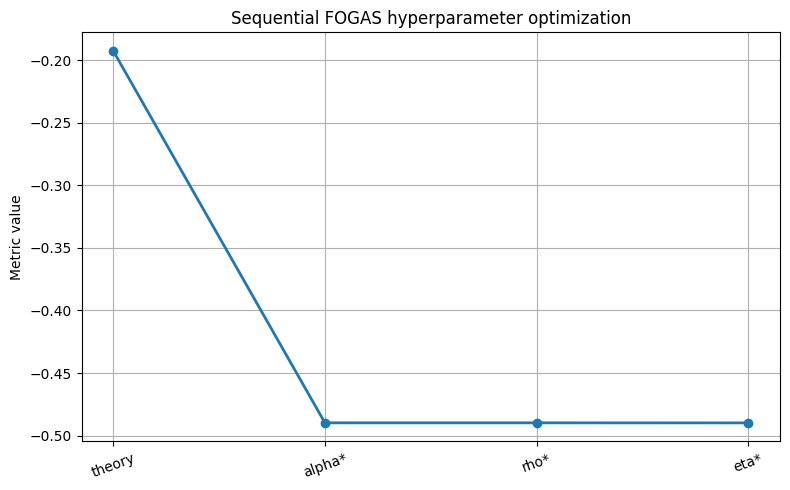

In [16]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    print_search=True,
    num_runs=2,
    order=("alpha", "rho", "eta")
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]

In [17]:
solver.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True, verbose=True, print_policies=True)
evaluator.compare_value_functions()


Iteration 1
  State 0: π(a=0|s=0) = 0.25  π(a=1|s=0) = 0.25  π(a=2|s=0) = 0.25  π(a=3|s=0) = 0.25  --> best action: 0
  State 1: π(a=0|s=1) = 0.25  π(a=1|s=1) = 0.25  π(a=2|s=1) = 0.25  π(a=3|s=1) = 0.25  --> best action: 0
  State 2: π(a=0|s=2) = 0.25  π(a=1|s=2) = 0.25  π(a=2|s=2) = 0.25  π(a=3|s=2) = 0.25  --> best action: 0
  State 3: π(a=0|s=3) = 0.25  π(a=1|s=3) = 0.25  π(a=2|s=3) = 0.25  π(a=3|s=3) = 0.25  --> best action: 0
  State 4: π(a=0|s=4) = 0.25  π(a=1|s=4) = 0.25  π(a=2|s=4) = 0.25  π(a=3|s=4) = 0.25  --> best action: 0
  State 5: π(a=0|s=5) = 0.25  π(a=1|s=5) = 0.25  π(a=2|s=5) = 0.25  π(a=3|s=5) = 0.25  --> best action: 0
  State 6: π(a=0|s=6) = 0.25  π(a=1|s=6) = 0.25  π(a=2|s=6) = 0.25  π(a=3|s=6) = 0.25  --> best action: 0
  State 7: π(a=0|s=7) = 0.25  π(a=1|s=7) = 0.25  π(a=2|s=7) = 0.25  π(a=3|s=7) = 0.25  --> best action: 0
  State 8: π(a=0|s=8) = 0.25  π(a=1|s=8) = 0.25  π(a=2|s=8) = 0.25  π(a=3|s=8) = 0.25  --> best action: 0


[FOGAS Oracle] Iter 1/1000
  θ_

NOT CONVERGING BECAUSE INDEPENDENT OF THE STATE.

## 2 - DEFINITION (CONVERGES)

**Feature Map**

We use a structured linear feature representation over state–action pairs that decomposes into row features, action features, and a terminal indicator.

The state space is a (3 \times 3) grid with
$$
\mathcal{X} = {0,\dots,8}, \quad \mathcal{A} = {0,1,2,3}.
$$

Let $ \text{row}(x) \in \{0,1,2\}$ denote the row index of state (x).
The feature map is defined as
$$
\phi(x,a) \in \mathbb{R}^{d}, \qquad d = 3 * 4 + 1 = 13.
$$

It has the following structure:
$$
\phi(x,a): \; \; (x,a) \;\longrightarrow\; e_{\; \text{row}(x) \; \cdot \; |\mathcal{A}|\; + \; a},
$$

Thus:

* The **first 12 coordinates** encode the one-hot encoding of the pair (row - action).
* The **last coordinate** is a terminal-state indicator for the goal state (x=8).

**Reward Weights**

The reward function is linear in the features:
$$
r(x,a) = \phi(x,a)^\top \omega.
$$

The weight vector $\omega \in \mathbb{R}^{13}$ is defined as
$$
\omega =
\begin{bmatrix}
0 \ 0 \ 0 \ 0 \ 0 \ 0 \ 0 \ 0 \ 0 \ 0 \ 0 \ 0 \ 1
\end{bmatrix}.
$$

This yields:
$$
r(x,a) =
\begin{cases}
1 & \text{if } x = 8 \;\; (\text{goal state}), \\
0 & \text{otherwise}.
\end{cases}
$$

**Transition Model**

The transition matrix
$$
P \in \mathbb{R}^{(9\cdot 4) \times 9}
$$
is defined such that each row corresponding to $(x,a)$ contains a single 1 at column $x'$:

$$
P_{(x,a),x'} =
\begin{cases}
1 & \text{if } x' = \text{next\_state}(x,a), \\
0 & \text{otherwise}.
\end{cases}
$$


## Testing

In [24]:
states = np.arange(9)
actions = np.arange(4)
N = len(states) # number of states
A = len(actions) # number of actions
gamma = 0.9

x_0 = 0 # fixed initial state

goal = 8   # absorbing terminal state

# Helper to convert index <-> (row, col)
def to_rc(s):  return divmod(s, 3)
def to_s(r,c): return r*3 + c

d = (N // 3) * A + 1   # 3*4 + 1 = 13

def phi(state, action):
    r, _ = to_rc(state)
    f = np.zeros(d)
    f[r * A + action] = 1.0
    f[-1] = 1.0 if state == goal else 0.0
    return f

omega = np.zeros(d)
omega[d - 1] = 1.0

def next_state(s, a):
    if s == goal:
        return goal  # absorbing: if we reach that state we stay in that state

    r, c = to_rc(s)

    if a == 0:  # Up
        r = max(0, r-1)
    elif a == 1:  # Down
        r = min(2, r+1)
    elif a == 2:  # Left
        c = max(0, c-1)
    elif a == 3:  # Right
        c = min(2, c+1)

    return to_s(r, c)

P_grid = np.zeros((N * A, N))
count = 0
for x in range(N):
    for a in range(A):
        xp = next_state(x, a)     # deterministic next state
        for xp_ in range(N):
            if xp_ == xp:
                P_grid[count, xp_] = 1.0
            else:
                P_grid[count, xp_] = 0.0
        count += 1

mdp = PolicySolver(states=states, actions=actions, phi=phi, omega=omega, gamma=gamma, x0=x_0, P=P_grid)

### Oracle

In [25]:
solver = FOGASOracleSolverVectorized(
    mdp=mdp, 
    cov_matrix="identity", 
    print_params=True, 
    T=1000
)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"), seed=seed)


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     1.4142
Num states N:             9
Num actions A:            4
Feature dim d:            13
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      18510257.052780736
T (iterations):                1000   (overridden → 1000)

FOGAS Hyperparameters
---------------------
alpha:                        0.001033
rho:                            2.154492
eta:                            0.000033
D_theta:                    11.401754
beta (ridge):             0.000154
D_pi (derived):           11.774100





=== FOGAS Hyperparameter Optimization ===
[Initial] metric = -0.1563
Order: ('eta', 'rho', 'alpha')

Optimizing eta
[After eta*] alpha=1.0327e-03, rho=5.0000e+00, eta=4.4747e-02 | metric = -0.2064

Optimizing rho
[After rho*] alpha=1.0327e-03, rho=1.0000e-02, eta=4.4747e-02 | metric = -0.4642

Optimizing alpha
[After alpha*] alpha=5.7476e-02, rho=1.0000e-02, eta=4.4747e-02 | metric = -0.6561


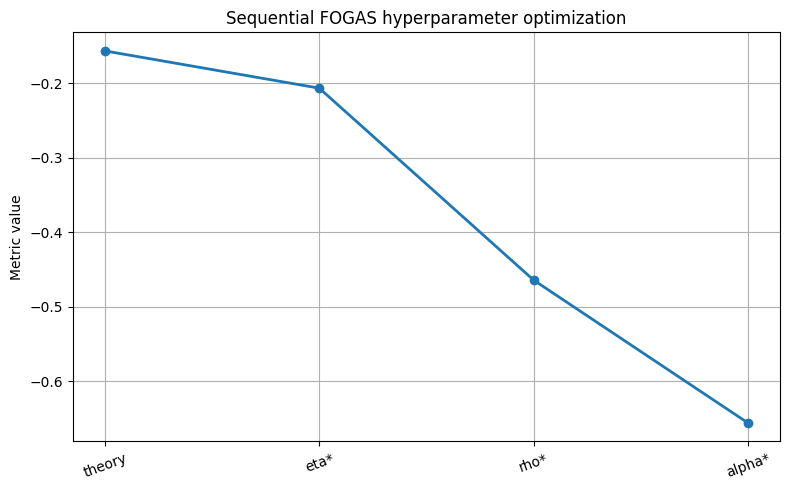

In [27]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2,
    order=("eta", "rho", "alpha")
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]

In [28]:
solver.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True, verbose=True, print_policies=True)
evaluator.compare_value_functions()
evaluator.print_policy()


Iteration 1
  State 0: π(a=0|s=0) = 0.25  π(a=1|s=0) = 0.25  π(a=2|s=0) = 0.25  π(a=3|s=0) = 0.25  --> best action: 0
  State 1: π(a=0|s=1) = 0.25  π(a=1|s=1) = 0.25  π(a=2|s=1) = 0.25  π(a=3|s=1) = 0.25  --> best action: 0
  State 2: π(a=0|s=2) = 0.25  π(a=1|s=2) = 0.25  π(a=2|s=2) = 0.25  π(a=3|s=2) = 0.25  --> best action: 0
  State 3: π(a=0|s=3) = 0.25  π(a=1|s=3) = 0.25  π(a=2|s=3) = 0.25  π(a=3|s=3) = 0.25  --> best action: 0
  State 4: π(a=0|s=4) = 0.25  π(a=1|s=4) = 0.25  π(a=2|s=4) = 0.25  π(a=3|s=4) = 0.25  --> best action: 0
  State 5: π(a=0|s=5) = 0.25  π(a=1|s=5) = 0.25  π(a=2|s=5) = 0.25  π(a=3|s=5) = 0.25  --> best action: 0
  State 6: π(a=0|s=6) = 0.25  π(a=1|s=6) = 0.25  π(a=2|s=6) = 0.25  π(a=3|s=6) = 0.25  --> best action: 0
  State 7: π(a=0|s=7) = 0.25  π(a=1|s=7) = 0.25  π(a=2|s=7) = 0.25  π(a=3|s=7) = 0.25  --> best action: 0
  State 8: π(a=0|s=8) = 0.25  π(a=1|s=8) = 0.25  π(a=2|s=8) = 0.25  π(a=3|s=8) = 0.25  --> best action: 0


[FOGAS Oracle] Iter 1/1000
  θ_

### Empirical

In [29]:
solver_e = FOGASSolverVectorized(mdp=mdp, print_params=True, csv_path=str(DATASET_PATH), T=400)
evaluator_e = FOGASEvaluator(solver_e)
optimizer_e = FOGASHyperOptimizer(solver=solver_e,metric_callable=evaluator_e.get_metric("reward"), seed=seed)


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           150
Feature norm bound R:     1.4142
Num states N:             9
Num actions A:            4
Feature dim d:            13
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      277.65385579171107
T (iterations):                400   (overridden → 400)

FOGAS Hyperparameters
---------------------
alpha:                        0.001633
rho:                            531.692601
eta:                            0.000052
D_theta:                    11.401754
beta (ridge):             0.000385
D_pi (derived):           7.446595




Trying same optimal hyperparameters found for the oracle.

In [30]:
solver_e.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/400 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 400/400 [00:00<00:00, 8663.01it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  6.561000 | V^π(x) =  3.878082 | Δ = -2.682918e+00
State 1: V*(x) =  7.290000 | V^π(x) =  5.043433 | Δ = -2.246567e+00
State 2: V*(x) =  8.100000 | V^π(x) =  6.838229 | Δ = -1.261771e+00
State 3: V*(x) =  7.290000 | V^π(x) =  4.338867 | Δ = -2.951133e+00
State 4: V*(x) =  8.100000 | V^π(x) =  5.927396 | Δ = -2.172604e+00
State 5: V*(x) =  9.000000 | V^π(x) =  8.966354 | Δ = -3.364561e-02
State 6: V*(x) =  8.100000 | V^π(x) =  4.817160 | Δ = -3.282840e+00
State 7: V*(x) =  9.000000 | V^π(x) =  6.585450 | Δ = -2.414550e+00
State 8: V*(x) =  10.000000 | V^π(x) =  10.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  5.904900 | Q^π(x,a) =  3.490274 | Δ = -2.414626e+00
(x=0, a=1): Q*(x,a) =  6.561000 | Q^π(x,a) =  3.904980 | Δ = -2.656020e+00
(x=0, a=2): Q*(x,a) =  5.904900 | Q^π(x,a) =  3.490274 | Δ = -2.414626e+00
(x=0, a=3): Q*(x,a) =  6.561000 | Q^π(x,a) =  4.539090 | Δ

Try first alpha, end eta.


=== FOGAS Hyperparameter Optimization ===
[Initial] metric = -0.2780
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=2.0578e+00, rho=3.0000e+00, eta=1.0000e-02 | metric = -0.3471

Optimizing rho
[After rho*] alpha=2.0578e+00, rho=1.5029e-02, eta=1.0000e-02 | metric = -0.6515

Optimizing eta
[After eta*] alpha=2.0578e+00, rho=1.5029e-02, eta=2.1369e-02 | metric = -0.6559


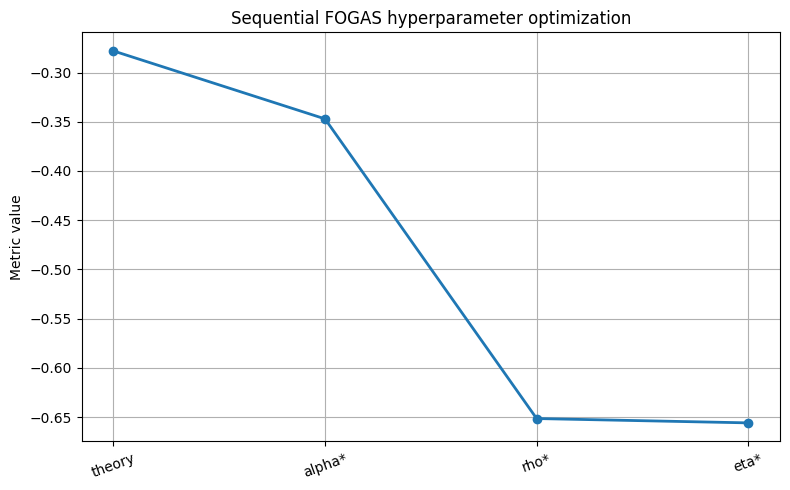

In [41]:
summary_e = optimizer_e.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=15,
    print_main=True, 
    num_runs=2,
    random_candidates=30,
    order=("alpha", "rho", "eta"),
    bounds_overrides={"alpha" : (1e-2, 5.0), "rho" : (1e-2, 3.0), "eta" : (1e-2, 3.0)}
)

alpha_star_e = summary_e["alpha"]
rho_star_e = summary_e["rho"]
eta_star_e = summary_e["eta"]

In [40]:
solver_e.run(alpha=alpha_star_e, eta=eta_star_e, rho=rho_star_e, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/400 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 400/400 [00:00<00:00, 5315.30it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  6.561000 | V^π(x) =  6.559423 | Δ = -1.577482e-03
State 1: V*(x) =  7.290000 | V^π(x) =  7.279746 | Δ = -1.025362e-02
State 2: V*(x) =  8.100000 | V^π(x) =  8.002135 | Δ = -9.786526e-02
State 3: V*(x) =  7.290000 | V^π(x) =  7.288249 | Δ = -1.751205e-03
State 4: V*(x) =  8.100000 | V^π(x) =  8.088610 | Δ = -1.138983e-02
State 5: V*(x) =  9.000000 | V^π(x) =  8.891264 | Δ = -1.087359e-01
State 6: V*(x) =  8.100000 | V^π(x) =  8.099549 | Δ = -4.508262e-04
State 7: V*(x) =  9.000000 | V^π(x) =  8.999749 | Δ = -2.510976e-04
State 8: V*(x) =  10.000000 | V^π(x) =  10.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  5.904900 | Q^π(x,a) =  5.903480 | Δ = -1.419734e-03
(x=0, a=1): Q*(x,a) =  6.561000 | Q^π(x,a) =  6.559424 | Δ = -1.576084e-03
(x=0, a=2): Q*(x,a) =  5.904900 | Q^π(x,a) =  5.903480 | Δ = -1.419734e-03
(x=0, a=3): Q*(x,a) =  6.561000 | Q^π(x,a) =  6.551772 | Δ